### Проект по исследованию пользователей мобильного приложения по продаже продуктов питания

Необходимо исследовать поведение пользователей мобильного приложения, оценить результаты А/А/В тестирования

### План работы

1. Ознакомиться с данными
2. Предобработка данных (преобразовать названия столбцов, проверить пропуски и типы данных, добавить столбец даты и времени)
3. Исследовать данные (определить количество событий в логе, количество пользователей, сколько событий приходится на пользователя, определить макс. и мин. даты, проверить распределение пользователей по группам)
4. Проанализировать воронку событий(Определить события в датасете, в каком порядке происходят события,расчитать соотношения пользователей к предыдущему шагу, доля польхователей доходящих до оплаты)
5. Изучить результаты эксперимента (есть ли разница между выборками, сравнить группы по событиям)
6. Сформулировать вывод

### Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math as mth
import numpy as np
import datetime as dt
from scipy import stats as st


In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [3]:
display(data.head(5))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Предобработка данных

In [5]:
data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id','EventTimestamp':'event_time', 'ExpId':'exp_id'})
display(data.head(5))

,event_name,user_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
display(data.isna().sum())

event_name    0
user_id       0
event_time    0
exp_id        0
dtype: int64

In [7]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['date']= pd.to_datetime(data['event_time'], unit='s').dt.date
data['month']= pd.to_datetime(data['event_time'], unit='s').dt.month
display(data)
data.info()

,event_name,user_id,event_time,exp_id,date,month
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,7
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,7
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,7
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,8
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,8
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,8
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  object        
 5   month       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [8]:
display(data['event_name'].unique())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [9]:
display(data.duplicated().sum())

413

In [10]:
data = data.drop_duplicates().reset_index(drop=True)
data.head(5)

,event_name,user_id,event_time,exp_id,date,month
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,7
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,7
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,7


Вывод: изначальный датасет на 244126 строки. Названия столбцов приведены к нижнему регистру. Даты в верный формат, добавлен столбец 'date' - только даты без времени. Пропуски отсутвуют. Было найдено 413 дубликатов. После удаления дубликатов остались данные на 243713 строки.

## Проверка данных

###### Количество событий в логе

In [11]:
display('Событий в логе: ',data['event_name'].count())

'Событий в логе: '

243713

###### Количество событий в логе

In [12]:
display('Всего пользователей в логе: ', data['user_id'].nunique())

'Всего пользователей в логе: '

7551

###### Количество событий на пользователя

In [13]:
users_cnt_avg = data.groupby('user_id', as_index=False).agg({'event_time':'count'}).sort_values(by='event_time', ascending=False)
users_cnt_avg.columns=['user_id', 'count']
display('Количество событий на одного пользователя', users_cnt_avg.head())

'Количество событий на одного пользователя'

,user_id,count
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221


In [14]:
users_cnt_avg['count'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: count, dtype: float64

In [15]:
display('В среднем событий на пользователя:', users_cnt_avg['count'].mean())

'В среднем событий на пользователя:'

32.27559263673685

In [16]:
display('Перцентили событий на пользователя:', np.percentile(users_cnt_avg['count'], [90, 95, 99])) 

'Перцентили событий на пользователя:'

array([ 64. ,  89. , 200.5])

###### Определим исслудемый период,найдем максимальную и минимальную дату. 

In [17]:
display('Начало исследуемого периода:', data['date'].min())
display('Окончание исследуемого периода:', data['date'].max())

'Начало исследуемого периода:'

datetime.date(2019, 7, 25)

'Окончание исследуемого периода:'

datetime.date(2019, 8, 7)

###### Определим за какой период мы располагаем данными

date,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07
exp_id,,,,,,,,,,,,,,
246,4,14,24,33,55,129,620,11561,10946,10575,11514,12368,11726,10612
247,1,8,23,36,58,138,664,12306,10990,11024,9942,10949,11720,10091
248,4,9,8,36,71,145,746,12274,13618,11683,11512,12741,12342,10393


Text(0.5, 0, 'Дата и время')

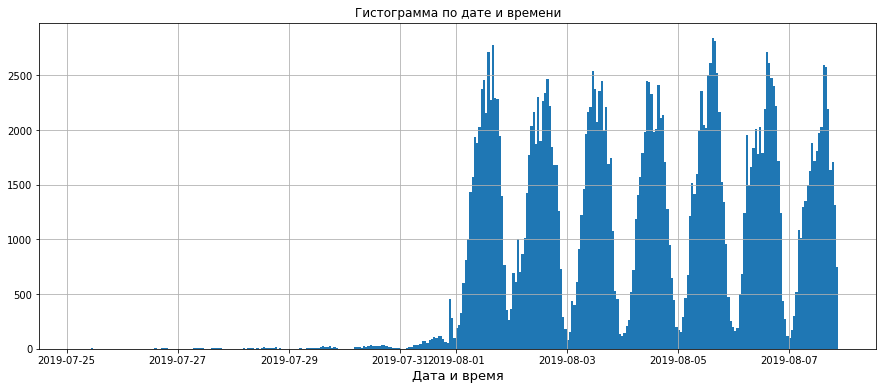

In [18]:
data_pivot = data.pivot_table(index='exp_id', columns='date', values='user_id', aggfunc='count')
display(data_pivot)
data['event_time'].hist(bins=14*24, figsize=(15,6))
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата и время', fontsize=13)

Вывод: Рассматриваемый период с 25/07/2019 по 07/08/2019. Полные данные в логе с 01/08/2019. Не полные с 25/07/2019 по 31/07/2019.


###### найдем id пользователей, с перецентилем более 95

In [19]:
ninty_perc_users = users_cnt_avg.query('count>90')
ninty_perc_users = ninty_perc_users['user_id']

data_fil = data.query('user_id not in @ninty_perc_users')
display(data_fil.head())  

,event_name,user_id,event_time,exp_id,date,month
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,7
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,7
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,7


In [20]:
data_july = data_fil.loc[data_fil['month']==7]
data_new = data_fil.loc[data_fil['month']==8]

display(data_july)
display(data_new)

,event_name,user_id,event_time,exp_id,date,month
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,7
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,7
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,7
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,7
...,...,...,...,...,...,...
2821,OffersScreenAppear,2413191300976302222,2019-07-31 23:54:55,247,2019-07-31,7
2822,MainScreenAppear,5505110279185484837,2019-07-31 23:57:30,247,2019-07-31,7
2823,MainScreenAppear,5505110279185484837,2019-07-31 23:57:42,247,2019-07-31,7
2824,MainScreenAppear,5505110279185484837,2019-07-31 23:57:52,247,2019-07-31,7


,event_name,user_id,event_time,exp_id,date,month
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,8
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,8
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,8
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,8
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,8
...,...,...,...,...,...,...
243707,MainScreenAppear,5746969938801999050,2019-08-07 21:12:11,246,2019-08-07,8
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,8
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,8
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,8


In [21]:
print('Количество потерянных событий после удаления дубликатов и анoмалий:', len(data) - len(data_fil))
print('Количество потерянных пользователей после удаления дубликатов и анoмалий:', len(data['user_id'].unique()) - len(data_fil['user_id'].unique()))

print('Количество потерянных событий после удаления данных неполного периода:', len(data_fil)-len(data_new))
print('Количество потерянных пользователей после удаления данных неполного периода:', len(data_fil['user_id'].unique()) - len(data_new['user_id'].unique()))

Количество потерянных событий после удаления дубликатов и анoмалий: 69982
Количество потерянных пользователей после удаления дубликатов и анoмалий: 361
Количество потерянных событий после удаления данных неполного периода: 2410
Количество потерянных пользователей после удаления данных неполного периода: 17


In [22]:
print('Доля потерянных событий после удаления данных неполного периода:','{0:.2%}'.format((len(data_fil)-len(data_new))/len(data_fil)))
print('Доля потерянных пользователей после удаления данных неполного периода:', '{0:.2%}'.format((len(data_fil['user_id'].unique()) - len(data_new['user_id'].unique()))/len(data_fil['user_id'].unique())))

Доля потерянных событий после удаления данных неполного периода: 1.39%
Доля потерянных пользователей после удаления данных неполного периода: 0.24%


Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [23]:
grouped_users = data_new.groupby('exp_id', as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id':'quantity'})
display('Распределение пользователей по группам', grouped_users)

'Распределение пользователей по группам'

,exp_id,quantity
0,246,2365
1,247,2399
2,248,2409


Вывод: После удаления дубликатов в предыдущем шаге осталось 243 713 события. Пользователй в логе 7551. В среднем на одного события приходится по 32 события. У 75% пользователей приходится 37 событий. Максимальное число событий 2307. Стандартное отклонение 65,15. Начало периода 25/07/2019, а окончание - 07/08/2019. Полные данные в логе с 01/08/2019. Не полные с 25/07/2019 по 31/07/2019. Количество неполных данных - 2410 (данные в июле). Были оставлены данные за август - 171321. Распределение по группам следующее: 246	- (2365), 247 - (2399), 248 - (2409)

### Изучение воронки событий

###### Выявим какие события есть в логе

In [24]:
data_new.groupby('event_name', as_index=False).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,event_name,user_id
1,MainScreenAppear,99416
2,OffersScreenAppear,32187
0,CartScreenAppear,22124
3,PaymentScreenSuccessful,16667
4,Tutorial,927


Вывод: MainScreenAppear - наибольшее кол-во событий - 99416. Количество у OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful находится примерно в одном диапазоне - 32187, 22124, 16667 соответственно. Самое наименьшее кол-во у Tutorial - 927.

###### Определим сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
cnt_event = data_new.groupby('event_name', as_index=False).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending = False)
cnt_event['percent'] = round(cnt_event['user_id']/data_fil['user_id'].nunique(),2)
display(cnt_event)

,event_name,user_id,percent
1,MainScreenAppear,7063,0.98
2,OffersScreenAppear,4245,0.59
0,CartScreenAppear,3397,0.47
3,PaymentScreenSuccessful,3205,0.45
4,Tutorial,776,0.11


###### Предположим в каком порядке происходят события

In [26]:
grouped_by_event = data_new.groupby('event_name', as_index=False).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
display(grouped_by_event)

,event_name,user_id
1,MainScreenAppear,7063
2,OffersScreenAppear,4245
0,CartScreenAppear,3397
3,PaymentScreenSuccessful,3205
4,Tutorial,776


Вывод: События в логе: CartScreenAppear(Появление экрана с корзиной), MainScreenAppear(Появление главного экрана), OffersScreenAppear(Появление экрана с предложением), PaymentScreenSuccessful(Появление экрана с успешной оплатой), Tutorial(Индивидуальное обучение)
Воронка - постепенное уменьшение количества событий от большего к меньшему. Соответственное расположение событий:

1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful
5. Tutorial

Логически названия событий соответсвуют количеству пользователей на каждом этапе, исходя из сводной таблицы.

###### Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [27]:
grouped_by_event['difference'] = round((grouped_by_event['user_id']/grouped_by_event['user_id'].shift(1))*100,2)
display('Доля пользователей переходящей на следующий этап воронки', grouped_by_event)

'Доля пользователей переходящей на следующий этап воронки'

,event_name,user_id,difference
1,MainScreenAppear,7063,NaN
2,OffersScreenAppear,4245,60.10
0,CartScreenAppear,3397,80.02
3,PaymentScreenSuccessful,3205,94.35
4,Tutorial,776,24.21


Вывод: соотношение пользователей в августе по датам: MainScreenAppear 60% перешло к следующему этапу OffersScreenAppear. С этапа OffersScreenAppear к CartScreenAppear перешло 80%, c этапа CartScreenAppear на PaymentScreenSuccessful	перешло 94%, от PaymentScreenSuccessful к Tutorial перешло 24% пользователей

###### Определим на каком шаге теряется больше всего пользователей

In [28]:
print('Потеря пользователей между этапом 1 и 2 :', grouped_by_event.iloc[0,1]-grouped_by_event.iloc[1,1])
print('Потеря пользователей между этапом 2 и 3 :',grouped_by_event.iloc[1,1]-grouped_by_event.iloc[2,1])
print('Потеря пользователей между этапом 3 и 4 :',grouped_by_event.iloc[2,1]-grouped_by_event.iloc[3,1])
print('Потеря пользователей между этапом 4 и 5 :',grouped_by_event.iloc[3,1]-grouped_by_event.iloc[4,1])

print('Доля потерь между этапом 1 и 2', '{0:.2%}'.format((grouped_by_event.iloc[0,1]-grouped_by_event.iloc[1,1])/sum(grouped_by_event['user_id'])))
print('Доля потерь между этапом 4 и 5', '{0:.2%}'.format((grouped_by_event.iloc[3,1]-grouped_by_event.iloc[4,1])/sum(grouped_by_event['user_id'])))

Потеря пользователей между этапом 1 и 2 : 2818
Потеря пользователей между этапом 2 и 3 : 848
Потеря пользователей между этапом 3 и 4 : 192
Потеря пользователей между этапом 4 и 5 : 2429
Доля потерь между этапом 1 и 2 15.08%
Доля потерь между этапом 4 и 5 13.00%


При анализе соотношения от этапа к этапу можно отметить, что больше всего теряется пользователей при перехоже с первого на второй этап(MainScreenAppear->OffersScreenAppear) - переходит 15% пользователей. И при переходе с 4 на 5 этап - PaymentScreenSuccessful->Tutorial - переходит 13% пользователей

###### Выявим какая доля пользователей доходит от первого события до оплаты

In [29]:
print('Доля пользователей,доходящих от первого события до оплаты: ', '{0:.2%}'.format(grouped_by_event.iloc[3,1]/grouped_by_event.iloc[0,1]))

Доля пользователей,доходящих от первого события до оплаты:  45.38%


Вывод:MainScreenAppear - наибольшее кол-во событий - 99416. Количество у OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful находится примерно в одном диапазоне - 32187, 22124, 16667 соответственно. Самое наименьшее кол-во у Tutorial - 927.

События в логе: CartScreenAppear(Появление экрана с корзиной), MainScreenAppear(Появление главного экрана), OffersScreenAppear(Появление экрана с предложением), PaymentScreenSuccessful(Появление экрана с успешной оплатой), Tutorial(Индивидуальное обучение)
Воронка - постепенное уменьшение количества событий от большего к меньшему. Соответственное расположение событий:

1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful
5. Tutorial

Логически названия событий соответсвуют количеству пользователей на каждом этапе, исходя из сводной таблицы.

Cоотношение пользователей в августе по датам: MainScreenAppear 60% перешло к следующему этапу OffersScreenAppear. С этапа OffersScreenAppear к CartScreenAppear перешло 80%, c этапа CartScreenAppear на PaymentScreenSuccessful перешло 94%, от PaymentScreenSuccessful к Tutorial перешло 24% пользователей

При анализе соотношения от этапа к этапу можно отметить, что больше всего теряется пользователей при перехоже с первого на второй этап(MainScreenAppear->OffersScreenAppear) - переходит 15% пользователей. И при переходе с 4 на 5 этап - PaymentScreenSuccessful->Tutorial - переходит 13% пользователей

### Изучение результатов эксперимента

###### Выявим сколько пользователей в каждой экспериментальной группе

In [30]:
grouped_data = data_new.groupby('exp_id', as_index=False).agg({'user_id':'nunique'})
display('Распределение уникальных пользователей по группам', grouped_data)

'Распределение уникальных пользователей по группам'

,exp_id,user_id
0,246,2365
1,247,2399
2,248,2409


###### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим находятся ли статистические критерии разницу между выборками 246 и 247.

In [31]:
groped_events = data_new.pivot_table(index = 'exp_id', columns='event_name', values='user_id', aggfunc='nunique').reset_index()
groped_events['Total'] = grouped_data['user_id']
display(groped_events)

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,Total
0,246,1154,2332,1427,1088,253,2365
1,247,1134,2365,1411,1055,268,2399
2,248,1109,2366,1407,1062,255,2409


In [46]:
print(groped_events.iloc[0,1], groped_events.iloc[1,1], groped_events.iloc[0,6], groped_events.iloc[1,6])

1154 1134 2365 2399


###### Сформулируем гипотезу:

Нулевая гипотеза: различий в долях между выборками 246 и 247 нет

Альтернативная гипотеза: различия в долях между выборками 246 и 247 есть. 

In [32]:
alpha = 0.05

In [33]:
def show_results(index_1, index_2):
    if index_1 < index_2:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [34]:
def z_test(successes_1, successes_2, trials_1, trials_2, alpha):
    # пропорция успехов в первой группе:
    p1 = successes_1/trials_1

    # пропорция успехов во второй группе:
    p2 = successes_2/trials_2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    result_1 = print('p-значение: ', p_value)
    
    result_2 = show_results(p_value, alpha)
    
    return result_1, result_2

In [35]:
columns = [1,2,3,4,5]

for column in columns:
    print('Проверка гипотезы о равности долей групп 246 и 247 по событию',groped_events.columns[column])
    z_test(groped_events.iloc[0,column], groped_events.iloc[1,column], groped_events.iloc[0,6], groped_events.iloc[1,6], alpha)
    print('_____________________________________________________________________________________________')

Проверка гипотезы о равности долей групп 246 и 247 по событию CartScreenAppear
p-значение:  0.2920961972474885
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
_____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246 и 247 по событию MainScreenAppear
p-значение:  0.9488058453077359
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
_____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246 и 247 по событию OffersScreenAppear
p-значение:  0.2844644518221826
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
_____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246 и 247 по событию PaymentScreenSuccessful
p-значение:  0.15956763723683043
Не получилось отвергнуть нулев

#### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. 

In [36]:
popular_event = groped_events[['exp_id','MainScreenAppear', 'Total']].copy()
popular_event['rate'] = round((popular_event['MainScreenAppear']/popular_event['Total'])*100,2)
popular_event

event_name,exp_id,MainScreenAppear,Total,rate
0,246,2332,2365,98.60
1,247,2365,2399,98.58
2,248,2366,2409,98.22


In [37]:
popular_event = groped_events[['exp_id','CartScreenAppear', 'Total']].copy()
popular_event['rate'] = round((popular_event['CartScreenAppear']/popular_event['Total'])*100,2)
popular_event

event_name,exp_id,CartScreenAppear,Total,rate
0,246,1154,2365,48.79
1,247,1134,2399,47.27
2,248,1109,2409,46.04


In [38]:
popular_event = groped_events[['exp_id','OffersScreenAppear', 'Total']].copy()
popular_event['rate'] = round((popular_event['OffersScreenAppear']/popular_event['Total'])*100,2)
popular_event

event_name,exp_id,OffersScreenAppear,Total,rate
0,246,1427,2365,60.34
1,247,1411,2399,58.82
2,248,1407,2409,58.41


In [39]:
popular_event = groped_events[['exp_id','Tutorial', 'Total']].copy()
popular_event['rate'] = round((popular_event['Tutorial']/popular_event['Total'])*100,2)
popular_event

event_name,exp_id,Tutorial,Total,rate
0,246,253,2365,10.70
1,247,268,2399,11.17
2,248,255,2409,10.59


###### Сделаем тоже самое с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. 

In [40]:
groped_events.loc[3] = groped_events.loc[0] + groped_events.loc[1]
groped_events

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,Total
0,246,1154,2332,1427,1088,253,2365
1,247,1134,2365,1411,1055,268,2399
2,248,1109,2366,1407,1062,255,2409
3,493,2288,4697,2838,2143,521,4764


Сформулируем гипотезы:

1. Нулевая гипотеза: различий в долях между выборками 246 и 248 нет. Альтернативная гипотеза: различия в долях между выборками 246 и 248 есть.

2. Нулевая гипотеза: различий в долях между выборками 247 и 248 нет. Альтернативная гипотеза: различия в долях между выборками 247 и 248 есть.

In [43]:
groped_events.iloc[0,6]

2365

In [41]:
columns = [1,2,3,4,5]

for column in columns:
    print('Проверка гипотезы о равности долей групп 246 и 248 по событию',groped_events.columns[column])
    z_test(groped_events.iloc[0,column], groped_events.iloc[2,column], groped_events.iloc[0,6], groped_events.iloc[2,6], alpha)
    
    print('Проверка гипотезы о равности долей групп 247 и 248 по событию',groped_events.columns[column])
    z_test(groped_events.iloc[1,column], groped_events.iloc[2,column], groped_events.iloc[1,6], groped_events.iloc[2,6], alpha)
    
    print('____________________________________________________________________________________________')

Проверка гипотезы о равности долей групп 246 и 248 по событию CartScreenAppear
p-значение:  0.05626720797991558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равности долей групп 247 и 248 по событию CartScreenAppear
p-значение:  0.3911281023781876
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246 и 248 по событию MainScreenAppear
p-значение:  0.2822092595945087
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка гипотезы о равности долей групп 247 и 248 по событию MainScreenAppear
p-значение:  0.30983823318398684
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246 и 248 по со

In [42]:
columns = [1,2,3,4,5]

for column in columns:
    print('Проверка гипотезы о равности долей групп 246+247 и 248 по событию',groped_events.columns[column])
    z_test(groped_events.iloc[2,column], groped_events.iloc[3,column], groped_events.iloc[2,6], groped_events.iloc[3,6], alpha)
    
    print('____________________________________________________________________________________________')

Проверка гипотезы о равности долей групп 246+247 и 248 по событию CartScreenAppear
p-значение:  0.11068078406757342
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246+247 и 248 по событию MainScreenAppear
p-значение:  0.2178174063864624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246+247 и 248 по событию OffersScreenAppear
p-значение:  0.342740437463807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
____________________________________________________________________________________________
Проверка гипотезы о равности долей групп 246+247 и 248 по событию PaymentScreenSuccessful
p-значение:  0.46973441160530083
Не получилось отв

Вывод:На основании проверенных гипотез между группами 246, 247, 248 различий по событиям не выявленно. Скорее всего изменение шрифта никак не повлияло на прохождение пользователями всех этапов.

При проверке статистических гипотез был выбран уровень значимости 0,05. Было выполнено 20 проверок статистических гипотез. При использования значения 0,01 результат не изменился.

### Вывод: 

Проанализировали датасет (244 126 строки).

Выполнили предварительную предобработку датасета:

1. Названия столбцов приведены к нижнему регистру. 
2. Даты в верный формат, добавлен столбец 'date', 'month' - даты без времени и месяц в цифровом формате. 
3. Проверили на отстствие пропусков - 0.
4. Проверили на наличие дубликатов. Было найдено 413 дубликатов. После удаления дубликатов остались данные на 243 713 строки.
5. После удаления дубликатов осталоось 7 551 пользователей.

Расчитали, что в среднем на одного пользователя приходится по 32 события. На 75% пользователей приходится 37 событий. Максимальное число событий 2 307. Стандартное отклонение 65,15. 

Начало периода 25/07/2019, а окончание - 07/08/2019. Полные данные в логе отображаются с 01/08/2019. Не полные с 25/07/2019 по 31/07/2019. Количество данных в июле - 2 410(неполные данные). Были оставлены данные за август - 171 321. Распределение по группам следующее: 
1. 246 - (2365)
2. 247 - (2399)
3. 248 - (2409)

События в логе: CartScreenAppear(Появление экрана с корзиной), MainScreenAppear(Появление главного экрана), OffersScreenAppear(Появление экрана с предложением), PaymentScreenSuccessful(Появление экрана с успешной оплатой), Tutorial(Индивидуальное обучение) Воронка - постепенное уменьшение количества событий от большего к меньшему. Соответственное расположение событий:

1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful
5. Tutorial(не относится к воронке)

С этапа MainScreenAppear 60% перешло к следующему OffersScreenAppear. 
С этапа OffersScreenAppear к CartScreenAppear перешло 80%. 
С этапа CartScreenAppear на PaymentScreenSuccessful перешло 94%
С PaymentScreenSuccessful к Tutorial перешло 24% пользователей.

При анализе соотношения от этапа к этапу можно отметить, что больше всего теряется пользователей при перехоже с первого на второй этап(MainScreenAppear->OffersScreenAppear) - переходит 15% пользователей. И при переходе с 4 на 5 этап - PaymentScreenSuccessful->Tutorial - переходит 13% пользователей

Наибольшее кол-во событий у MainScreenAppear - 99416. Количество у OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful находится примерно в одном диапазоне - 32187, 22124, 16667 соответственно. Самое наименьшее кол-во у Tutorial - 927.

Было выполнено 20 проверок статистических гипотез. Было проанализировано три группы уникалбных пользователей: 246, 247, 248. Группы 246 и 247 - контрольные, 248 - эксперементальная. 2 контрольные группы со старыми шрифтами и одна экспериментальная — с новыми. Гипотеза о том, что новый шрифт увеличит число пользователей, доходящих до последнего этапа оплаты, не подтвердилась. 
Провери сравнения групп 246 и 247, 246 и 248, 247 и 248, 246+247 и 248. Значимых различий между группами обнаружено не было.

Большая часть пользователей(2818) теряется при переходе с первого этапа на второй (от просмотра экрана на экран с предложением) и при переходе с 4 на 5 этап(2429) (с экрана оплаты на экран с индивидуальным обучением).

Рекомендации: на мой взгляд один из вариантов проверить технические ошибки приложения на этапах, на которых теряется наибольшее количество пользователей. Второй - продлить срок исследования на несколько недель больше.